# Predicting Bike count in Munich

To get some pratical experience I chose my own project to practice the concepts introduced in Chapter 9 "Tabular Modelling Deep Dive" of the fastai_v2 course. I wanted to share my approach and would be happy if you could point me to errors, misunderstandings or possible improvements.

1. [Goal](#introduction)
2. [Data](#data)
    1. [Get data](#getdata)
    1. [Explore data](#exploredata)
3. [Modelling](#model)
    1. [Random Forest](#rf)
    2. [Neuronal Net](#nn)    
4. [Analyze results](#analyze)
5. [Improvements](#improve)
6. [Conclusion and next steps](#conclusion)

## 1. My Goal <a name="introduction"></a>

The city of munich counts the number of bikers on six counting stations throughout munich. They provide those numbers to the public in their open data portal.

Based on this data, can I create a model that predicts the number of bikers for a given day?

## 2. The data <a name="data"></a>

At the momente there are 6 permanent bike counting stations in munich. They count bikes with sensors build into the street. The data can be accessed via the open data portal api. e.g. all currently available datasets can be retrieved with this call: https://www.opengov-muenchen.de/api/3/action/package_search?q=Raddauerz%C3%A4hlstellen&rows=1000

In April 2020 the counting station Kreuther changed. The sensor size approximatly doubled in size. Take this into account for data after 1. april.

More information:

* OpenDataPortal Munich Website (german): https://www.opengov-muenchen.de/dataset?tags=Raddauerz%C3%A4hlstellen
* Info about bike counting stations (Raddauerzählstellen) (german): https://www.opengov-muenchen.de/pages/raddauerzaehlstellen
* API Doku: https://docs.ckan.org/en/ckan-2.5.3/api/
* Analysis of data 2017 & 2018 in german - [„Aufs Radl – Fertig? – Los!“ Ergebnisse der Raddauerzählstellen in München 2017 und 2018 (PDF)](https://www.muenchen.de/rathaus/dam/jcr:9a65625e-952f-470f-b6a1-d4270f4526cb/mb190304.pdf)


### 2.1 Get data <a name="getdata"></a>

In [1]:
import requests
import os
import itertools

In [2]:
r = requests.get('https://www.opengov-muenchen.de/api/3/action/package_search?q=Raddauerz%C3%A4hlstellen&rows=1000')
json = r.json()

In [3]:
#json

In [4]:
def download_csv(url):
    filename = 'data/' + url.rsplit('/',1)[1]
    if os.path.exists(filename):
        print(f'{filename} already exists')
    else:
        r = requests.get(url)
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        with open(filename, 'wb') as f:
            f.write(r.content)
        print(f'{filename} downloaded.')

In [5]:
resources = [[{'name':res['name'], 'url':res['url']} for res in result['resources'] if res['name'] != 'Raddauerzählstellen in München'] for result in json['result']['results']]
resources = list(itertools.chain.from_iterable(resources))

In [6]:
for res in resources:
    download_csv(res['url'])

data/rad20170615min.csv already exists
data/rad201706tage.csv already exists
data/rad20201015min.csv already exists
data/rad202010tage.csv already exists
data/rad20200915min.csv already exists
data/rad202009tage.csv already exists
data/rad20200815min.csv already exists
data/rad202008tage.csv already exists
data/rad20200715min.csv already exists
data/rad202007tage.csv already exists
data/rad20200615min.csv already exists
data/rad202006tage.csv already exists
data/rad20200115min.csv already exists
data/rad202001tage.csv already exists
data/rad20200315min.csv already exists
data/rad202003tage.csv already exists
data/rad20200215min.csv already exists
data/rad202002tage.csv already exists
data/rad20190415min.csv already exists
data/rad201904tage.csv already exists
data/rad20181115min.csv already exists
data/rad201811tage.csv already exists
data/rad20170715min.csv already exists
data/rad201707tage.csv already exists
data/rad20170115min.csv already exists
data/rad201701tage.csv already exists

### 2.2. Explore data

In [7]:
# pip install pandas

In [8]:
import pandas as pd

In [9]:
files = [f for f in os.listdir('data') if os.path.isfile(os.path.join('data', f))]
files.sort()

#### Data complete?
For each month there should be two csv files (15 min und day). Therefore there should 92 files `(3 years * 12 month + 10 (10 for october)) * 2`

In [10]:
len(files) == (3 * 12 + 10) * 2

True

#### How does the data look like?

In [11]:
df_min15 = pd.read_csv('data/rad20201015min.csv')
df_min15

,datum,uhrzeit_start,uhrzeit_ende,zaehlstelle,richtung_1,richtung_2,gesamt
0,2020.10.01,00:00,00:15,Arnulf,2,0,2
1,2020.10.01,00:15,00:30,Arnulf,1,0,1
2,2020.10.01,00:30,00:45,Arnulf,0,0,0
3,2020.10.01,00:45,01:00,Arnulf,0,0,0
4,2020.10.01,01:00,01:15,Arnulf,1,0,1
...,...,...,...,...,...,...,...
17851,2020.10.31,22:45,23:00,Erhardt,5,14,19
17852,2020.10.31,23:00,23:15,Erhardt,8,11,19
17853,2020.10.31,23:15,23:30,Erhardt,5,9,14
17854,2020.10.31,23:30,23:45,Erhardt,5,9,14


In [12]:
df_day = pd.read_csv('data/rad202010tage.csv')
df_day

,datum,uhrzeit_start,uhrzeit_ende,zaehlstelle,richtung_1,richtung_2,gesamt,min-temp,max-temp,niederschlag,bewoelkung,sonnenstunden
0,2020.10.01,00:00,23.59,Arnulf,1738,107,1845,6.5,19.4,0.0,65,8.2
1,2020.10.02,00:00,23.59,Arnulf,1469,89,1558,9.8,18.4,0.0,99,0.9
2,2020.10.03,00:00,23.59,Arnulf,548,37,585,5.1,22.1,2.9,75,2.9
3,2020.10.04,00:00,23.59,Arnulf,821,37,858,4.7,17.3,0.7,73,6.5
4,2020.10.05,00:00,23.59,Arnulf,1048,63,1111,9.0,14.6,4.7,98,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...
181,2020.10.27,00:00,23.59,Erhardt,2289,2213,4502,3.9,11.1,0.0,75,1.5
182,2020.10.28,00:00,23.59,Erhardt,2675,2592,5267,3.5,14.7,2.4,95,1.3
183,2020.10.29,00:00,23.59,Erhardt,1334,1342,2676,8.9,11.2,15.5,94,0.0
184,2020.10.30,00:00,23.59,Erhardt,2167,2142,4309,9.0,14.7,0.0,99,0.6


* Every file contains all counting_stations (zaehlstelle).
* The counts are in three columns: direction_1 (richtung_1), direction_2 (richtung_2) and total (gesamt)
* The day datasets also contain weather information - min/max temp, sun hours, rain and cloud

In [13]:
# Available counting stations (zaehlstellen):
df_day.zaehlstelle.unique()

array(['Arnulf', 'Kreuther', 'Olympia', 'Hirsch', 'Margareten', 'Erhardt'],
      dtype=object)

In [14]:
# getDataframe of datafiles
# - prefixes - filter used files by prefix e.g. rad2018 for year 2018
# - zaehlstelle - filter by given counting station ()
def getDataframe(prefixes, zaehlstelle: str):
    files = [f for f in os.listdir('data') if os.path.isfile(os.path.join('data', f)) and f.endswith('tage.csv')]
    files = [f for f in files if f.startswith(prefixes)]
    df = pd.concat([pd.read_csv(os.path.join('data', f)) for f in files])
    return df[df.zaehlstelle == zaehlstelle].sort_values(by=['datum'])

In [15]:
df_arnulf = getDataframe(zaehlstelle='Arnulf', prefixes = ('rad2017', 'rad2018', 'rad2019'))

In [16]:
df_arnulf

,datum,uhrzeit_start,uhrzeit_ende,zaehlstelle,richtung_1,richtung_2,gesamt,min-temp,max-temp,niederschlag,bewoelkung,sonnenstunden
0,2017.01.01,00:00:00,23.59,Arnulf,121,14,135,-6.1,2.6,0.0,36,5.9
1,2017.01.02,00:00:00,23.59,Arnulf,362,38,400,-5.4,0.8,3.2,69,0.3
2,2017.01.03,00:00:00,23.59,Arnulf,232,30,262,-2.1,0.6,0.0,85,3.6
3,2017.01.04,00:00:00,23.59,Arnulf,182,25,207,-0.9,1.3,2.2,94,0.0
4,2017.01.05,00:00:00,23.59,Arnulf,193,31,224,-7.1,-0.2,0.0,88,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
26,2019.12.27,00:00,23.59,Arnulf,312,30,342,1.7,4.9,4.9,98,0.0
27,2019.12.28,00:00,23.59,Arnulf,337,37,374,-2.1,2.0,0.0,69,3.2
28,2019.12.29,00:00,23.59,Arnulf,253,32,285,-4.8,2.5,0.0,26,7.9
29,2019.12.30,00:00,23.59,Arnulf,550,52,602,-4.4,6.0,0.0,9,8.0


#### Are there missing days?

In [17]:
from datetime import date, timedelta, datetime

def findMissingDays(df):
    dates = df.datum.map(lambda x: datetime.strptime(x, '%Y.%m.%d')).tolist()
    dates.sort()
    d = set(dates[0] + timedelta(x) for x in range((dates[-1] - dates[0]).days))
    return sorted(d - set(dates))

In [18]:
missing = findMissingDays(df_arnulf)
len(missing), missing[0], missing[-1]

(61, Timestamp('2019-06-01 00:00:00'), Timestamp('2019-07-31 00:00:00'))

There are missing days from June to July 2019

#### Plot counts for a month

In [19]:
# pip install matplotlib

In [20]:
import matplotlib.pyplot as plt
import numpy as np

In [21]:
plt.rcParams['figure.figsize'] = [20, 15]

df = getDataframe(prefixes=('rad2018'), zaehlstelle='Arnulf')

<ipython-input-22-f5cfea7d9034>:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.axes()


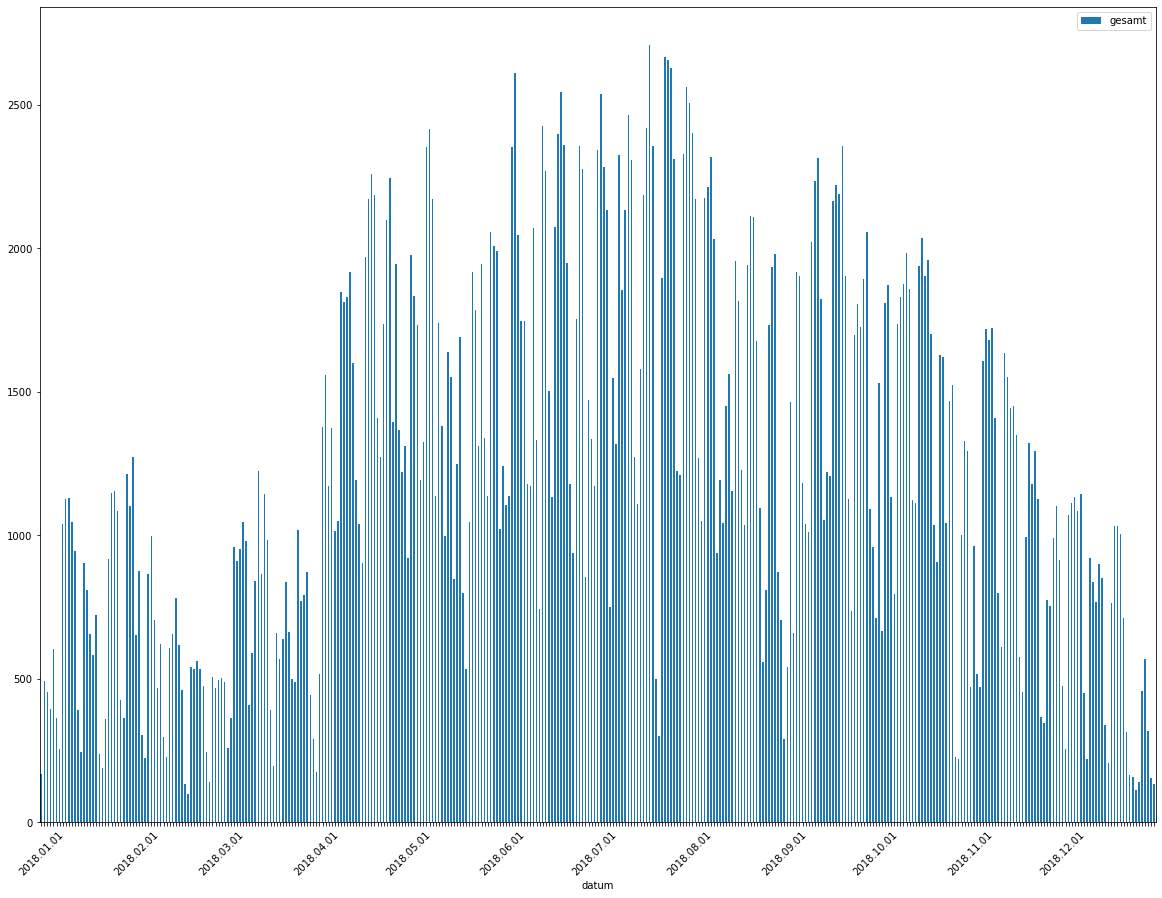

In [22]:
df.plot.bar(x='datum', y='gesamt', rot=45)
ax1 = plt.axes()
x_axis = ax1.axes.get_xaxis()
for index, label in enumerate(x_axis.get_ticklabels()):
    if not label.get_text().endswith('01'):
        label.set_visible(False)
plt.show()
plt.close()

## 3. Modelling <a name="model"></a>

I will work with the daily numbers because they already contain the weather information.
I will use the year 2017 & 2018 as training data and 2019 for validation.

### 3.1. Random Forest <a name="rf"></a>

#### Prepare data

In [23]:
# conda install -c fastai -c pytorch fastai

In [24]:
from fastai.tabular.all import *

/opt/conda/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729096996/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [25]:
df = getDataframe(prefixes=('rad2017', 'rad2018', 'rad2019'), zaehlstelle='Arnulf')
# add date columns like day of week etc. 
df = add_datepart(df, 'datum')
df.head()

,uhrzeit_start,uhrzeit_ende,datumWeek,zaehlstelle,richtung_1,richtung_2,gesamt,min-temp,max-temp,niederschlag,...,datumDay,datumDayofweek,datumDayofyear,datumIs_month_end,datumIs_month_start,datumIs_quarter_end,datumIs_quarter_start,datumIs_year_end,datumIs_year_start,datumElapsed
0,00:00:00,23.59,52,Arnulf,121,14,135,-6.1,2.6,0.0,...,1,6,1,False,True,False,True,False,True,1483228800
1,00:00:00,23.59,1,Arnulf,362,38,400,-5.4,0.8,3.2,...,2,0,2,False,False,False,False,False,False,1483315200
2,00:00:00,23.59,1,Arnulf,232,30,262,-2.1,0.6,0.0,...,3,1,3,False,False,False,False,False,False,1483401600
3,00:00:00,23.59,1,Arnulf,182,25,207,-0.9,1.3,2.2,...,4,2,4,False,False,False,False,False,False,1483488000
4,00:00:00,23.59,1,Arnulf,193,31,224,-7.1,-0.2,0.0,...,5,3,5,False,False,False,False,False,False,1483574400


In [26]:
# drop richtung columns because they sum up to gesamt value, which we want to predict
df = df.drop(['richtung_1', 'richtung_2'], axis=1)

In [27]:
# Create Tabular Pandas
procs = [Categorify, FillMissing] # processings or transformations
cond = (df.datumYear<2019)
train_idx = np.where(cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

dep_var = 'gesamt' # dependent variable, the number we want to predict

cont, cat = cont_cat_split(df, 1, dep_var=dep_var)
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [28]:
to.show(3)

,uhrzeit_start,uhrzeit_ende,datumWeek,zaehlstelle,datumIs_month_end,datumIs_month_start,datumIs_quarter_end,datumIs_quarter_start,datumIs_year_end,datumIs_year_start,datumElapsed,min-temp,max-temp,niederschlag,bewoelkung,sonnenstunden,datumYear,datumMonth,datumDay,datumDayofweek,datumDayofyear,gesamt
0,00:00:00,23.59,52,Arnulf,False,True,False,True,False,True,1483228800,-6.1,2.6,0.0,36,5.9,2017,1,1,6,1,135
1,00:00:00,23.59,1,Arnulf,False,False,False,False,False,False,1483315200,-5.4,0.8,3.2,69,0.3,2017,1,2,0,2,400
2,00:00:00,23.59,1,Arnulf,False,False,False,False,False,False,1483401600,-2.1,0.6,0.0,85,3.6,2017,1,3,1,3,262


In [29]:
# save
save_pickle((URLs.path()/'../to.pkl'), to)

#### Train Random Forest

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [31]:
xs,y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [32]:
def rf(xs, y, n_estimators=40, max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, min_samples_leaf=min_samples_leaf, max_features=max_features, oob_score=True).fit(xs,y)

In [33]:
# root mean square error - penalizes large differences. Would MAE be better as metric?
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [34]:
m = rf(xs, y)

In [35]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(153.477832, 293.671934)

In [36]:
mean_absolute_error(m.predict(xs), y),mean_absolute_error(m.predict(valid_xs), valid_y)

(109.65702609142153, 220.2170140588274)

In [37]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
r_mse(preds.mean(0), valid_y)

293.671934

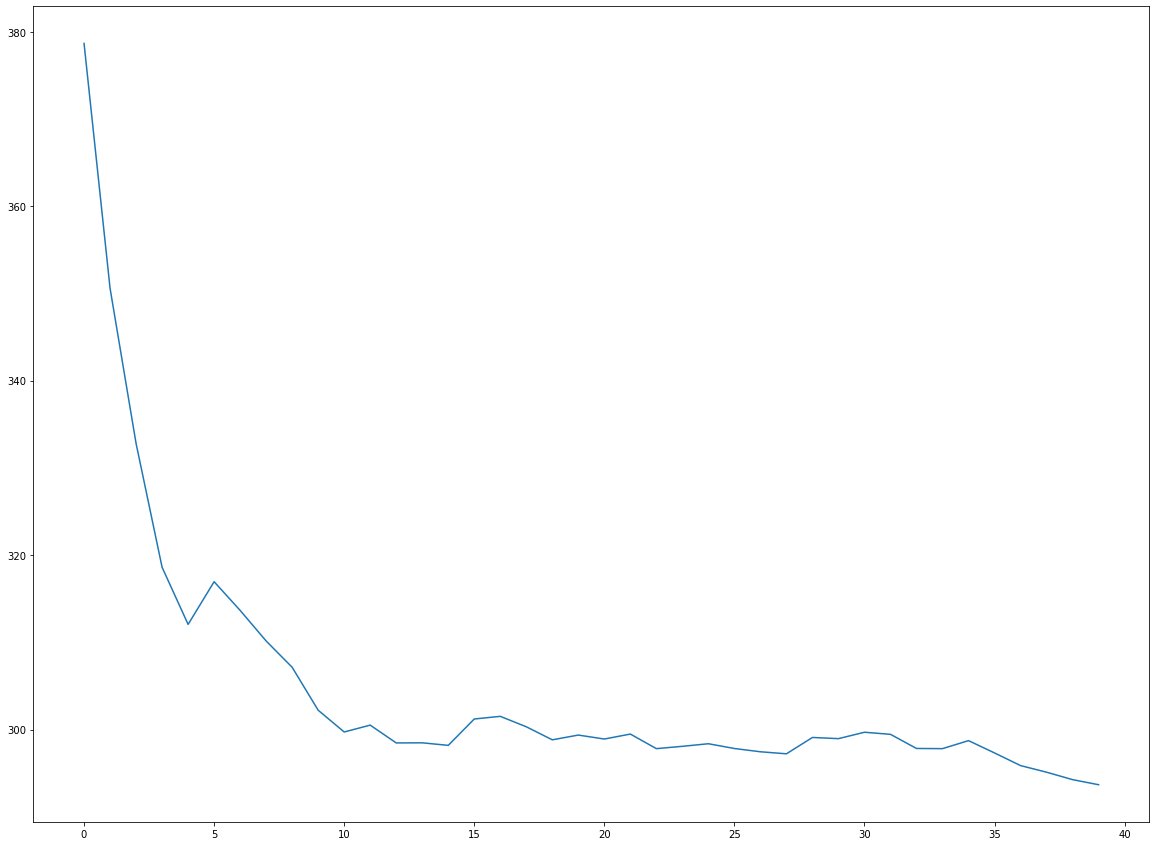

In [38]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

😳 Question: Best result in a previous run seem to be arround 20 not 40 what does that mean?

#### Out of bag error
Good metric to check why our predictions in our training set or better then in our validation set. 108.36805410446944 vs 212.6982400192359

In [39]:
r_mse(m.oob_prediction_, y)

223.275392

😳 Our error in the training set is higher than in the validation set. The example in the fastai book p.302 has an example where the error is lower.

What does this indicate?

#### Prediction confidence

how confident can I be in those predictions? One way is to look at the variance between the trees in the forest. Smaller is better.

In [40]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
print(preds.shape) # 40 trees, with 304 predictions for each day
preds_std = preds.std(0) # standard deviation
preds_std[:20]

(40, 304)


array([274.7184305 , 233.65713255, 241.40697189, 203.38162658,
        57.55733204,  55.90400176, 269.04874212, 189.78659779,
       175.57909927, 199.08264523, 205.3682141 ,  86.69497514,
        81.36701804, 190.08011092, 249.5200124 , 276.81426458,
       210.1592155 , 245.63738955, 121.95687933, 120.68516076])

#### Feature importance

Which feature are most important?

In [41]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
12,max-temp,0.378081
19,datumDayofweek,0.198147
15,sonnenstunden,0.139527
11,min-temp,0.137272
20,datumDayofyear,0.046788
13,niederschlag,0.027064
2,datumWeek,0.022901
14,bewoelkung,0.020216
10,datumElapsed,0.016275
18,datumDay,0.007746


Most important features are max-temp followed by day of week. Seems reasonable to me. e.g. workdays vs weekend and cold days vs warm days.

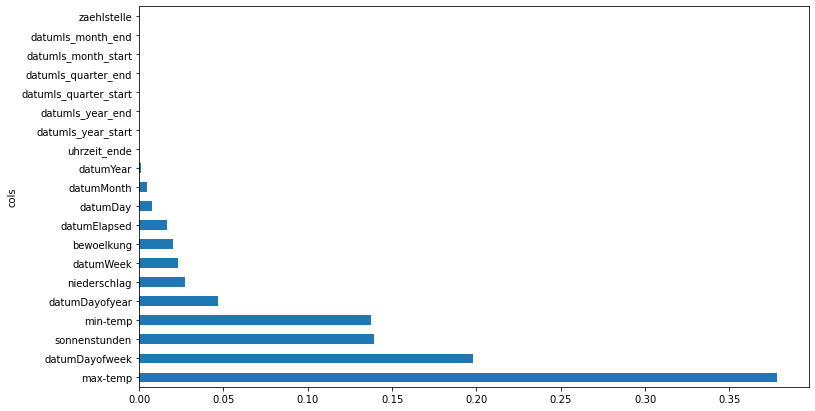

In [123]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:20]);

#### Remove unimportant features

In [43]:
to_keep =fi[fi.imp > 0.005].cols
len(to_keep)

10

In [44]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [45]:
m = rf(xs_imp, y)
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(155.023982, 292.665735)

😳 Got worse in comparison to prev run: 151.42499, 285.167373. But the removed columns shouldn't be important e.g. uhrzeit_start/end is always the same.

#### Redundant features

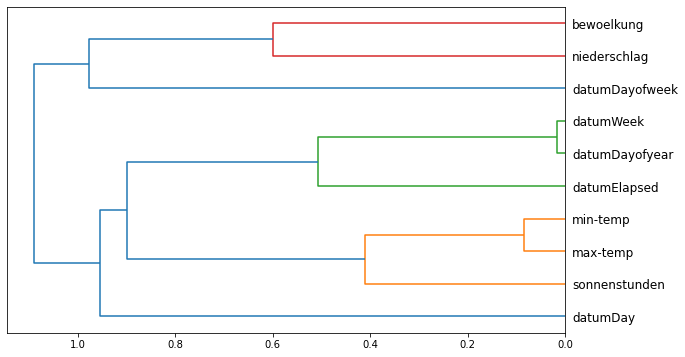

In [46]:
from scipy.cluster import hierarchy as hc

def cluster_columns(df, figsize=(10,6), font_size=12):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()
    
cluster_columns(xs_imp)

In [47]:
xs_imp.head()

,max-temp,datumDayofweek,sonnenstunden,min-temp,datumDayofyear,niederschlag,datumWeek,bewoelkung,datumElapsed,datumDay
0,2.6,6,5.9,-6.1,1,0.0,52,36,1,1
1,0.8,0,0.3,-5.4,2,3.2,1,69,2,2
2,0.6,1,3.6,-2.1,3,0.0,1,85,3,3
3,1.3,2,0.0,-0.9,4,2.2,1,94,4,4
4,-0.2,3,0.0,-7.1,5,0.0,1,88,5,5


month and day of year are close, makes sense both indicate the "season" or the progress into the year.
Will keep it for now.

#### Waterfall Chart

In [48]:
#!pip install treeinterpreter
#!pip install waterfallcharts

In [49]:
from treeinterpreter import treeinterpreter
row = valid_xs_imp.iloc[:1]
prediction,bias,contributions = treeinterpreter.predict(m, row.values)
prediction[0], bias[0], contributions[0].sum()

/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


(array([669.61353289]), 1176.2661986301368, -506.65266574349744)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

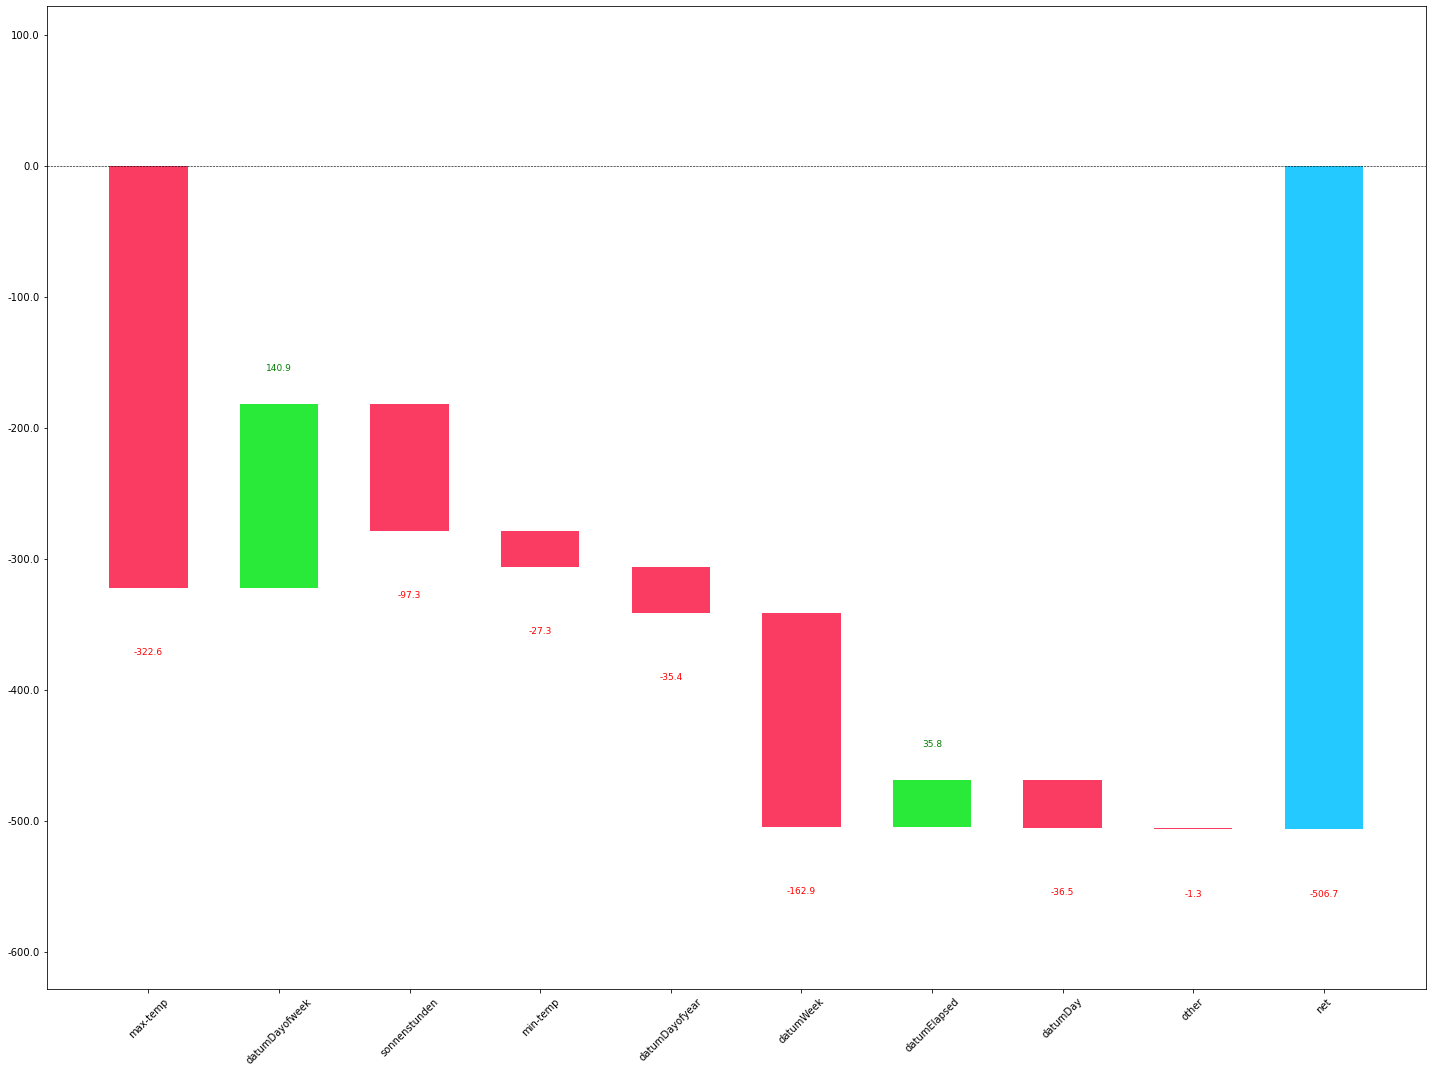

In [50]:
import waterfall_chart
waterfall_chart.plot(valid_xs_imp.columns, contributions[0], threshold=0.08, rotation_value=45)

Indicates the importance of different features for the prediction.

#### Out of domain data

In [51]:
df_dom = pd.concat([xs_imp, valid_xs_imp])
is_valid = np.array([0]*len(xs_imp) + [1]*len(valid_xs_imp))

In [52]:
# RandomForest to decide if value is in train oder valid set.
m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

,cols,imp
8,datumElapsed,0.958879
3,min-temp,0.012749
0,max-temp,0.012634
7,bewoelkung,0.003755
6,datumWeek,0.002873
4,datumDayofyear,0.002811


By extracting the most important features which seperate train from validation set we find feature which we could drop.

In [53]:
xs_final = xs_imp.drop('datumElapsed', axis=1)
valid_xs_final = valid_xs_imp.drop('datumElapsed', axis=1)
m = rf(xs_final, y)
print(f'without out of dom: {m_rmse(m, valid_xs_final, valid_y)}')

without out of dom: 284.683368


😳 Got worse again.

### Summary of RandomForest

In [54]:
m = rf(xs, y)
print(f'orig: {m_rmse(m, valid_xs, valid_y)}')
m = rf(xs_imp, y)
print(f'imp: {m_rmse(m, valid_xs_imp, valid_y)}')
m = rf(xs_imp.drop('datumElapsed',axis=1), y)
print(f'without out of dom: {m_rmse(m, valid_xs_imp.drop("datumElapsed",axis=1), valid_y)}')

orig: 287.91052
imp: 290.178617
without out of dom: 286.275386


#### less trees

In [55]:
m = rf(xs, y, 25)
print(f'orig: {m_rmse(m, valid_xs, valid_y)}')
m = rf(xs_imp, y, 25)
print(f'imp: {m_rmse(m, valid_xs_imp, valid_y)}')
m = rf(xs_imp.drop('datumElapsed',axis=1), y, 25)
print(f'without out of dom: {m_rmse(m, valid_xs_imp.drop("datumElapsed",axis=1), valid_y)}')

orig: 289.908937
imp: 283.236989
without out of dom: 293.985873


#### Open questions

😳 Results change on every rerun. Therfore: How comparable are the results with the different changes then? 

Should I fix a seed for the RandomForest, is this possible?

### 3.1. Neural Net <a name="nn"></a>

Let's try it with a neural net

In [56]:
df_nn = getDataframe(zaehlstelle='Arnulf', prefixes = ('rad2017', 'rad2018', 'rad2019'))
df_nn = add_datepart(df_nn, 'datum')
df_nn = df_nn[list(xs_final.columns) + [dep_var]]
df_nn

,max-temp,datumDayofweek,sonnenstunden,min-temp,datumDayofyear,niederschlag,datumWeek,bewoelkung,datumDay,gesamt
0,2.6,6,5.9,-6.1,1,0.0,52,36,1,135
1,0.8,0,0.3,-5.4,2,3.2,1,69,2,400
2,0.6,1,3.6,-2.1,3,0.0,1,85,3,262
3,1.3,2,0.0,-0.9,4,2.2,1,94,4,207
4,-0.2,3,0.0,-7.1,5,0.0,1,88,5,224
...,...,...,...,...,...,...,...,...,...,...
26,4.9,4,0.0,1.7,361,4.9,52,98,27,342
27,2.0,5,3.2,-2.1,362,0.0,52,69,28,374
28,2.5,6,7.9,-4.8,363,0.0,52,26,29,285
29,6.0,0,8.0,-4.4,364,0.0,1,9,30,602


In [57]:
cont_nn, cat_nn = cont_cat_split(df_nn, max_card=9000, dep_var=dep_var)

In [58]:
cont_nn, cat_nn

(['max-temp', 'sonnenstunden', 'min-temp', 'niederschlag'],
 ['datumDayofweek', 'datumDayofyear', 'datumWeek', 'bewoelkung', 'datumDay'])

In [59]:
df_nn[cat_nn].nunique()

datumDayofweek      7
datumDayofyear    365
datumWeek          52
bewoelkung         81
datumDay           31
dtype: int64

In [60]:
df_nn=df_nn.astype('float')

procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn, procs_nn, cat_nn, cont_nn, splits=splits, y_names=dep_var)

In [61]:
dls = to_nn.dataloaders()

In [62]:
learn = tabular_learner(dls, y_range=(29,2707), layers=[500,250], n_out=1, loss_func=F.mse_loss)

SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=7.585775847473997e-07)

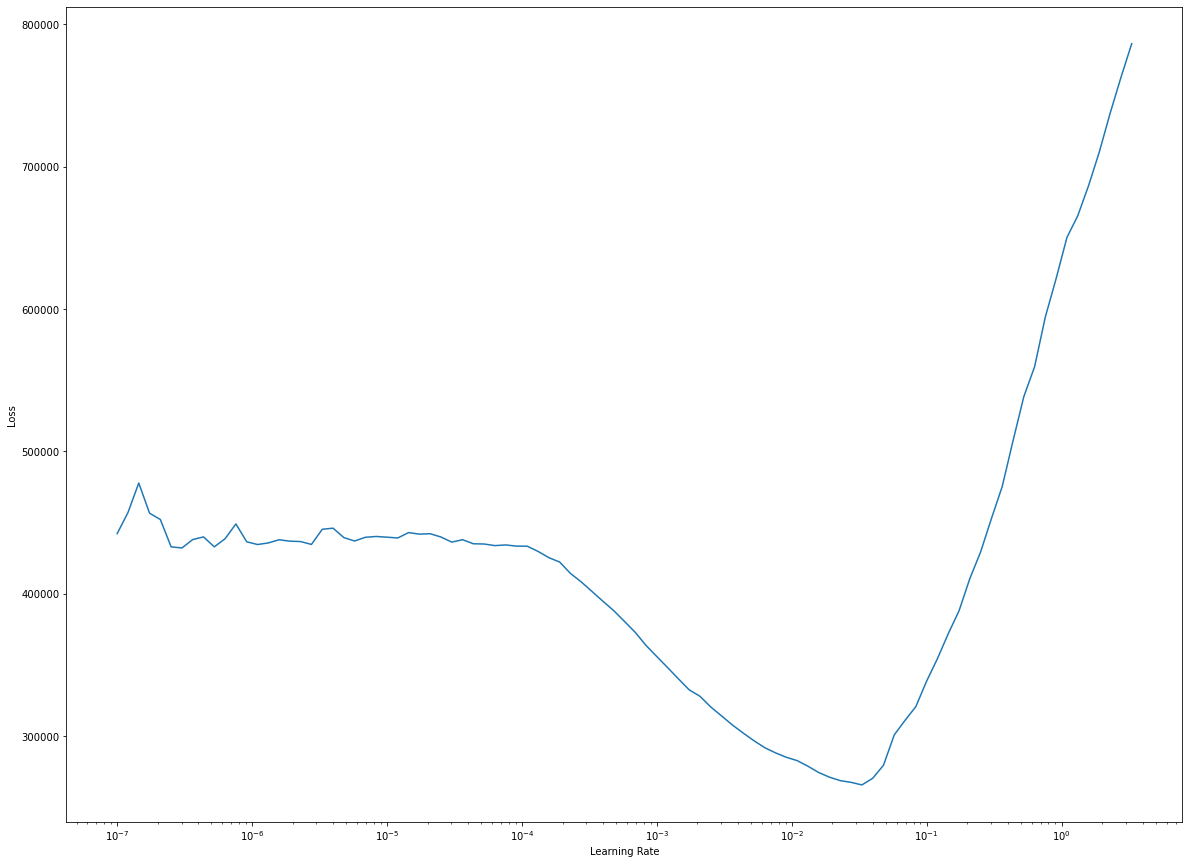

In [63]:
learn.lr_find()

In [64]:
learn.fit_one_cycle(20, 1e-2)

epoch,train_loss,valid_loss,time
0,234669.062500,246372.031250,00:00
1,169412.312500,176401.015625,00:00
2,142154.109375,183510.671875,00:00
3,122397.789062,130206.195312,00:00
4,101110.593750,130590.023438,00:00
5,89784.742188,119201.250000,00:00
6,78525.718750,103552.343750,00:00
7,69051.562500,111986.250000,00:00
8,63434.929688,113892.578125,00:00
9,55306.207031,94354.257812,00:00


In [65]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

290.215976

Is better than the random forest

## 4. Analyizing results <a name="analyze"></a>

### 4.1 Other metrics for evaluation?

Above I used the root mean square error to get a metric for the models. It is helpful to compare both models with each other. Are there other metrics that would help me to get a better understanding of the performance of the models?

In [66]:
# results
rf_m = rf(xs_final, y)

rf_preds = rf_m.predict(valid_xs_final)
nn_preds, nn_y = learn.get_preds()

In [67]:
from fastai import metrics

#### Root Mean Squared Error (RMSE)

In [68]:
# Root Mean Squared Error (RMSE)
print(r_mse(rf_preds, valid_y))
print(r_mse(nn_preds, nn_y))

290.346405
290.215976


Penalizes bigger errors more than MAE.

#### Mean absolute error (MAE)

In [69]:
# Mean absolute error (MAE)
def mae(preds, y): return np.abs(preds - y).mean()

print(mae(rf_preds, valid_y))
print(mae(nn_preds, nn_y).numpy())

221.92851825213108
216.30911


Allows a more intuitive understanding, as the error says, it is the mean absolute error. But could we set it in relation to range of values to get a better understanding?

#### Mean absolute percentage error (MAPE)

In [70]:
# Mean absolute percentage error (MAPE)
def mape(preds, y): return np.abs((y - preds) / y).mean()

print(mape(rf_preds, valid_y))
print(mape(nn_preds, nn_y).numpy())

0.34469792750873274
0.31876716


Ok so we are arround 28% off. Seems pretty high to me but maybe it is still useful for traffic planer?

#### normalized Mean Absolute Error / nMAE

In [71]:
def nmae(preds, y): return np.abs((preds - y)).mean() / preds.mean()

print(nmae(rf_preds, valid_y))
print(nmae(nn_preds, nn_y).numpy())

0.214701915905157
0.20063037


Another relative metric. Loses some of the details (outliers) etc. because the averaging is done after summing up all errors.

### 4.2 Visualize results

Could I get more insights by visualizing the data and results?

### Plot the results

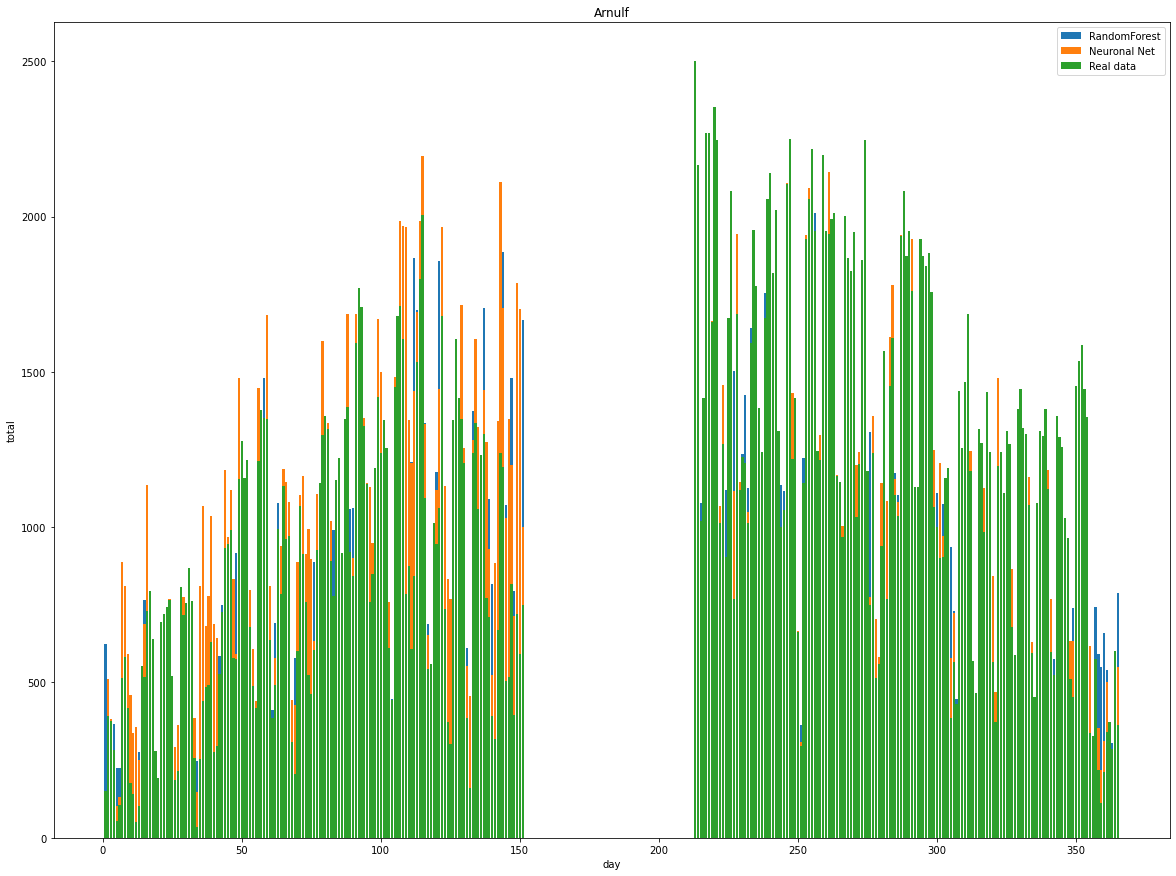

In [72]:
# plot a bar chart
plt.bar(valid_xs['datumDayofyear'], rf_preds, label='RandomForest')
plt.bar(valid_xs['datumDayofyear'], nn_preds, label='Neuronal Net')
plt.bar(valid_xs['datumDayofyear'], valid_y, label='Real data')
plt.xlabel('day')
plt.ylabel('total')
plt.title("Arnulf")
plt.legend();

Looks quite chaotic because it is too much data and small values are hidden behind the other bars. I played arround with a few different visualization but I think the cleanest one is following: 

In [73]:
df = getDataframe(prefixes=('rad2019'), zaehlstelle='Arnulf')

In [74]:
def addMissingDays(df):
    df['date'] = pd.to_datetime(df['datum'], format="%Y.%m.%d")
    idx = pd.date_range(df['date'].iloc[0], df['date'].iloc[-1])
    df.index = pd.DatetimeIndex(df['date'])
    df = df.reindex(idx)
    return df

In [75]:
df = addMissingDays(df)

In [76]:
def getPredsForRF(df):
    df = add_datepart(df, 'datum')
    results = pd.DataFrame(columns=['date', 'pred'])
    for index, x in df.iterrows():
        pred = -1
        if not pd.isnull(x['gesamt']):
            pred = rf_m.predict([x[list(xs_final.columns)]])[0]     
        dfTemp = pd.DataFrame(data={'date': [x['date']], 'pred': [pred]})
        results = results.append(dfTemp)
    return results

In [77]:
rf_2019 = getPredsForRF(df)

In [78]:
def plotResults(df, preds, s=0, n=365, title='Arnulf', label_df='2019', label_pred='RandomForest'):
    plt.bar(preds['date'][s:n], preds['pred'][s:n], label=label_pred, color='blue', width=0.8)
    plt.bar(df['date'][s:n], df['gesamt'][s:n], label=label_df, color='red', width=0.4)
    plt.xlabel('day')
    plt.ylabel('total')
    plt.title(title)
    plt.legend()

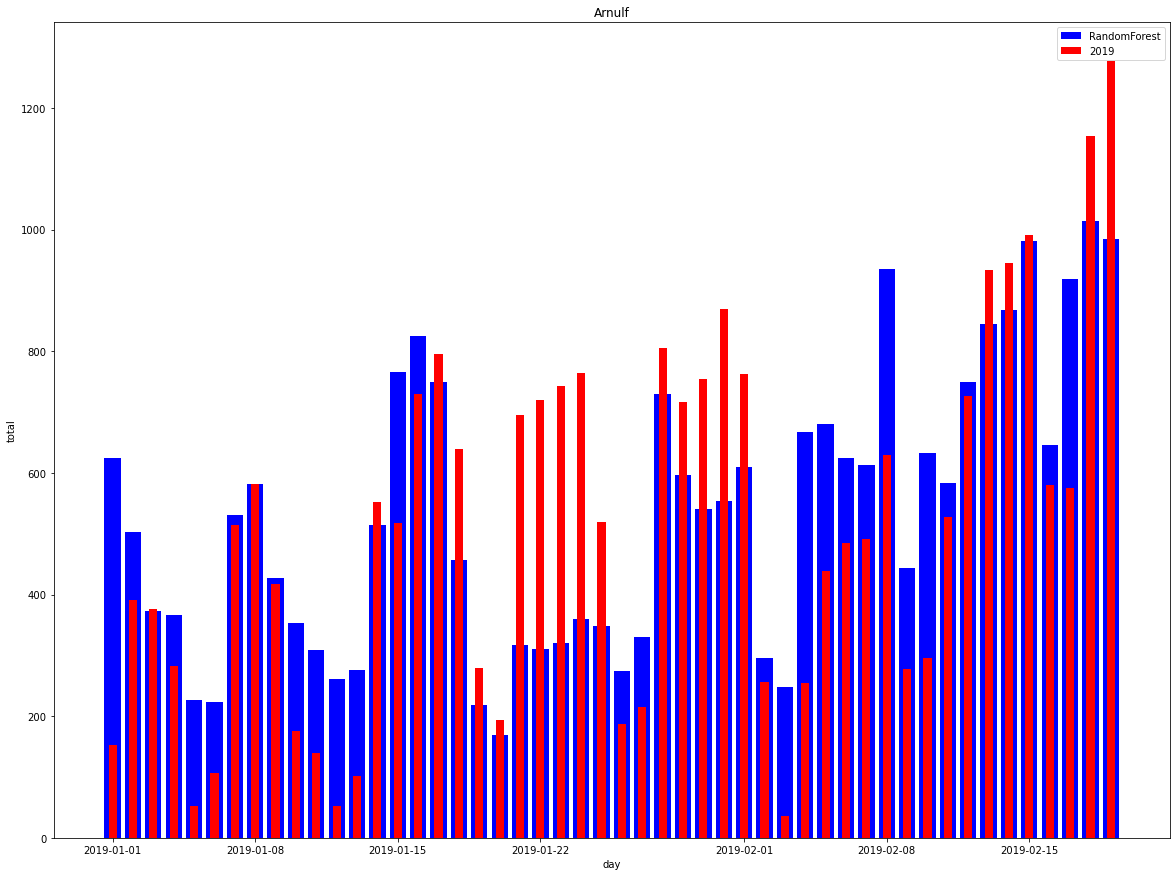

In [79]:
plotResults(df, rf_2019, n=50)

By stepping through different timeframes I can see big errors. But to be true I didn't identify anything useful. Maybe there is a better visualisation out there?

### 4.3 When do the biggest errors happen?

I would like to know what the reasons are for the errors. So I think it is a good idea to look at the biggest errors.

In [80]:
def getPredsForRF(df):
    df = add_datepart(df, 'datum')
    results = pd.DataFrame(columns=['date', 'pred'])
    for index, x in df.iterrows():
        pred = -1
        d = x['date']
        if not pd.isnull(x['gesamt']):
            pred = rf_m.predict([x[list(xs_final.columns)]])[0]
        dfTemp = pd.DataFrame(data={'date': index, 'pred': [pred]})
        results = results.append(dfTemp)
    return results

In [81]:
df2019 = getDataframe(prefixes=('rad2019'), zaehlstelle='Arnulf')
df2019 = addMissingDays(df2019)
preds2019RF = getPredsForRF(df2019)

In [82]:
errors = df2019['gesamt'].replace(np.NaN, -1).subtract(preds2019RF.set_index(preds2019RF.date)['pred'])

In [83]:
# top errors for random forest
errors.sort_values(ascending=False, key=lambda x: np.abs(x))[:20]

2019-04-19   -1142.909949
2019-05-30   -1099.506745
2019-04-22   -1024.018307
2019-05-31    -915.873021
2019-05-01    -796.376005
2019-08-15    -732.695634
2019-12-05     713.842115
2019-05-24    -692.161935
2019-10-22     662.970737
2019-05-27    -662.277323
2019-04-21    -599.506519
2019-09-20     597.690886
2019-05-23    -589.133709
2019-12-11     588.588973
2019-05-26    -583.634995
2019-05-25    -566.750939
2019-10-03    -555.810868
2019-11-01    -550.701965
2019-09-06     541.161308
2019-11-07     536.506263
dtype: float64

* 8 of 20 biggest erros happen on a national holiday (feiertag)
* 1 is durent a school holidays
* 1 is a "Brückentag"

So this looks like a promising way to improve my dataset by adding national holidays, school holidays to the dataset. In the future it might also be helpful to add "Brückentage" or days before a long weekend.


```
2019-04-19   -1180.442298 Karfreitag
2019-05-30   -1179.176310 Christi Himmelfahrt
2019-04-22   -1059.768092 Ostermontag
2019-05-31    -954.947565 Brückentag Christi Himmelfahrt
2019-08-15    -772.263989 Maria Himmelfahrt
2019-05-24    -744.230733 ?
2019-10-22     696.795180 ? 
2019-05-01    -695.081500 Schulferien Weihnachten
2019-12-05     674.750098 ?
2019-09-20     633.990541 ?
2019-05-23    -630.930030 ?
2019-05-26    -607.316037 ?
2019-10-03    -597.941322 Tag der deutschen Einheit
2019-11-01    -585.093491 Allerheiligen
2019-04-21    -565.883708 ?
2019-05-27    -565.291106 ?
2019-05-25    -544.784515 ?
2019-05-29    -538.861066 Mittwoch vor Feiertag
2019-09-27     537.904750 ?
2019-09-06     524.922845 Schulferien Sommer
```

## 5. Improvements <a name="improve"></a>

### 5.1 Add more features to dataset

#### National holidays / Feiertage

For national holidays there exists an API https://feiertage-api.de/

In [84]:
def getFeiertage(jahre = [2017,2018,2019], bundesland = 'BY', ignore = ['Augsburger Friedensfest']):
    feiertage_df = pd.DataFrame(columns={'date','name'})
    for jahr in jahre:
        r = requests.get(f'https://feiertage-api.de/api/?jahr={jahr}&nur_land={bundesland}')
        json = r.json()
        for key, d in json.items():
            if not key in ignore:
                feiertage_df = feiertage_df.append({'date': datetime.strptime(d['datum'], "%Y-%m-%d"), 'name':key}, ignore_index=True)
    return feiertage_df

In [85]:
getFeiertage()[:10]

,date,name
0,2017-01-01,Neujahrstag
1,2017-01-06,Heilige Drei Könige
2,2017-04-14,Karfreitag
3,2017-04-17,Ostermontag
4,2017-05-01,Tag der Arbeit
5,2017-05-25,Christi Himmelfahrt
6,2017-06-05,Pfingstmontag
7,2017-06-15,Fronleichnam
8,2017-08-15,Mariä Himmelfahrt
9,2017-10-03,Tag der Deutschen Einheit


#### School holidays / Schulferien

Also for this an open API exists: https://ferien-api.de/

In [86]:
def getFerientage(jahre = [2017,2018,2019], bundesland = 'BY'):
    ferientage_df = pd.DataFrame(columns={'date', 'name'})
    for jahr in jahre:
        r = requests.get(f'https://ferien-api.de/api/v1/holidays/{bundesland}/{jahr}')
        json = r.json()

        for f in json:
            start = datetime.strptime(f['start'], '%Y-%m-%dT%H:%MZ')
            end = datetime.strptime(f['end'], '%Y-%m-%dT%H:%MZ')
            dates = pd.date_range(start, end)

            df = pd.DataFrame({'date': dates, 'name':f['name']})

            ferientage_df = ferientage_df.append(df)
    return ferientage_df

In [87]:
getFerientage()[:10]

,date,name
0,2017-02-27,winterferien
1,2017-02-28,winterferien
2,2017-03-01,winterferien
3,2017-03-02,winterferien
4,2017-03-03,winterferien
5,2017-03-04,winterferien
0,2017-04-10,osterferien
1,2017-04-11,osterferien
2,2017-04-12,osterferien
3,2017-04-13,osterferien


### Add as additional columns

In [88]:
feiertage_df = getFeiertage()
ferientage_df = getFerientage()

In [89]:
def add_date_feature(df, name, dates):
    df[name] = False
    df.loc[df['date'].isin(dates), name] = True

In [90]:
df = getDataframe(prefixes=('rad2019'), zaehlstelle='Arnulf')
df['date'] = pd.to_datetime(df['datum'], format="%Y.%m.%d")
df = add_datepart(df, 'datum')
add_date_feature(df, 'feiertag', feiertage_df['date'])
add_date_feature(df, 'ferientag', ferientage_df['date'])
df[:1]

,uhrzeit_start,uhrzeit_ende,datumWeek,zaehlstelle,richtung_1,richtung_2,gesamt,min-temp,max-temp,niederschlag,...,datumDayofyear,datumIs_month_end,datumIs_month_start,datumIs_quarter_end,datumIs_quarter_start,datumIs_year_end,datumIs_year_start,datumElapsed,feiertag,ferientag
0,00:00:00,23.59,1,Arnulf,138,14,152,2.7,5.2,1.6,...,1,False,True,False,True,False,True,1546300800,True,True


### 5.2 RandomForest with new data

In [91]:
dep_var = 'gesamt' # dependent variable, the number we want to predict
usedColumns = np.append(xs_final.columns.values, ['feiertag', 'ferientag'])

In [92]:
df = getDataframe(zaehlstelle='Arnulf', prefixes = ('rad2017', 'rad2018', 'rad2019'))
df['date'] = pd.to_datetime(df['datum'], format="%Y.%m.%d")
df = add_datepart(df, 'datum')
add_date_feature(df, 'feiertag', feiertage_df['date'])
add_date_feature(df, 'ferientag', ferientage_df['date'])
df = df.drop(['richtung_1', 'richtung_2'], axis=1)
# df = df[list(usedColumns) + [dep_var]] reduce columns after train valid set is created because year is used
df

,uhrzeit_start,uhrzeit_ende,datumWeek,zaehlstelle,gesamt,min-temp,max-temp,niederschlag,bewoelkung,sonnenstunden,...,datumDayofyear,datumIs_month_end,datumIs_month_start,datumIs_quarter_end,datumIs_quarter_start,datumIs_year_end,datumIs_year_start,datumElapsed,feiertag,ferientag
0,00:00:00,23.59,52,Arnulf,135,-6.1,2.6,0.0,36,5.9,...,1,False,True,False,True,False,True,1483228800,True,False
1,00:00:00,23.59,1,Arnulf,400,-5.4,0.8,3.2,69,0.3,...,2,False,False,False,False,False,False,1483315200,False,False
2,00:00:00,23.59,1,Arnulf,262,-2.1,0.6,0.0,85,3.6,...,3,False,False,False,False,False,False,1483401600,False,False
3,00:00:00,23.59,1,Arnulf,207,-0.9,1.3,2.2,94,0.0,...,4,False,False,False,False,False,False,1483488000,False,False
4,00:00:00,23.59,1,Arnulf,224,-7.1,-0.2,0.0,88,0.0,...,5,False,False,False,False,False,False,1483574400,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,00:00,23.59,52,Arnulf,342,1.7,4.9,4.9,98,0.0,...,361,False,False,False,False,False,False,1577404800,False,True
27,00:00,23.59,52,Arnulf,374,-2.1,2.0,0.0,69,3.2,...,362,False,False,False,False,False,False,1577491200,False,True
28,00:00,23.59,52,Arnulf,285,-4.8,2.5,0.0,26,7.9,...,363,False,False,False,False,False,False,1577577600,False,True
29,00:00,23.59,1,Arnulf,602,-4.4,6.0,0.0,9,8.0,...,364,False,False,False,False,False,False,1577664000,False,True


In [93]:
# Create Tabular Pandas
procs = [Categorify, FillMissing] # processings or transformations
cond = (df.datumYear<2019)
train_idx = np.where(cond)[0]
valid_idx = np.where(~cond)[0]
splits = (list(train_idx),list(valid_idx))

cont, cat = cont_cat_split(df, 1, dep_var=dep_var)
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [94]:
xs,y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [95]:
xs = xs[list(usedColumns)]
valid_xs = valid_xs[list(usedColumns)]

In [96]:
m = rf(xs,y)

In [97]:
m_rmse(m, valid_xs, valid_y)

272.74979

😳better then version without holidays: first run 273 vs 287 old

Other metrics?

In [98]:
rf_preds = m.predict(valid_xs)
mae(rf_preds, valid_y), mape(rf_preds, valid_y), nmae(rf_preds, valid_y)

(210.09701086777324, 0.3237236660910646, 0.20322548194268697)

How important are the new features?

In [99]:
rf_feat_importance(m, xs)

,cols,imp
0,max-temp,0.355302
1,datumDayofweek,0.199496
2,sonnenstunden,0.149990
3,min-temp,0.138572
4,datumDayofyear,0.054694
6,datumWeek,0.031816
5,niederschlag,0.029401
7,bewoelkung,0.019608
10,ferientag,0.007093
9,feiertag,0.007064


#### Take another look at the biggest errors

In [100]:
rf_pred = m.predict(valid_xs)

In [101]:
error = np.subtract(rf_pred, valid_y).abs()

In [102]:
pd.options.mode.chained_assignment = None # avoid SettingWithCopyError, is this a good idea?
df_errors = df.iloc[valid_idx]
df_errors['pred'] = rf_pred
df_errors['error'] = error
df_errors.columns

Index(['uhrzeit_start', 'uhrzeit_ende', 'datumWeek', 'zaehlstelle', 'gesamt',
       'min-temp', 'max-temp', 'niederschlag', 'bewoelkung', 'sonnenstunden',
       'date', 'datumYear', 'datumMonth', 'datumDay', 'datumDayofweek',
       'datumDayofyear', 'datumIs_month_end', 'datumIs_month_start',
       'datumIs_quarter_end', 'datumIs_quarter_start', 'datumIs_year_end',
       'datumIs_year_start', 'datumElapsed', 'feiertag', 'ferientag', 'pred',
       'error'],
      dtype='object')

In [103]:
df_errors.sort_values(by = 'error', ascending=False)[['date', 'datumDayofweek', 'min-temp', 'feiertag', 'ferientag', 'error', 'gesamt', 'pred']][:10]

,date,datumDayofweek,min-temp,feiertag,ferientag,error,gesamt,pred
29,2019-05-30,3,8.6,True,False,987.986242,593,1580.986242
18,2019-04-19,4,5.5,True,True,987.227566,785,1772.227566
21,2019-04-22,0,6.5,True,True,955.340798,843,1798.340798
30,2019-05-31,4,11.7,False,False,931.509480,751,1682.509480
23,2019-05-24,4,6.3,False,False,729.712157,1194,1923.712157
14,2019-08-15,3,9.8,True,True,717.304553,769,1486.304553
26,2019-05-27,0,11.2,False,False,660.980998,817,1477.980998
21,2019-10-22,1,10.5,False,False,645.521575,1873,1227.478425
19,2019-09-20,4,3.4,False,False,631.003814,2011,1379.996186
0,2019-05-01,2,4.7,True,False,607.479866,1061,1668.479866


#### Plot biggest errors

Can I see clusters when plotting the biggest errors?

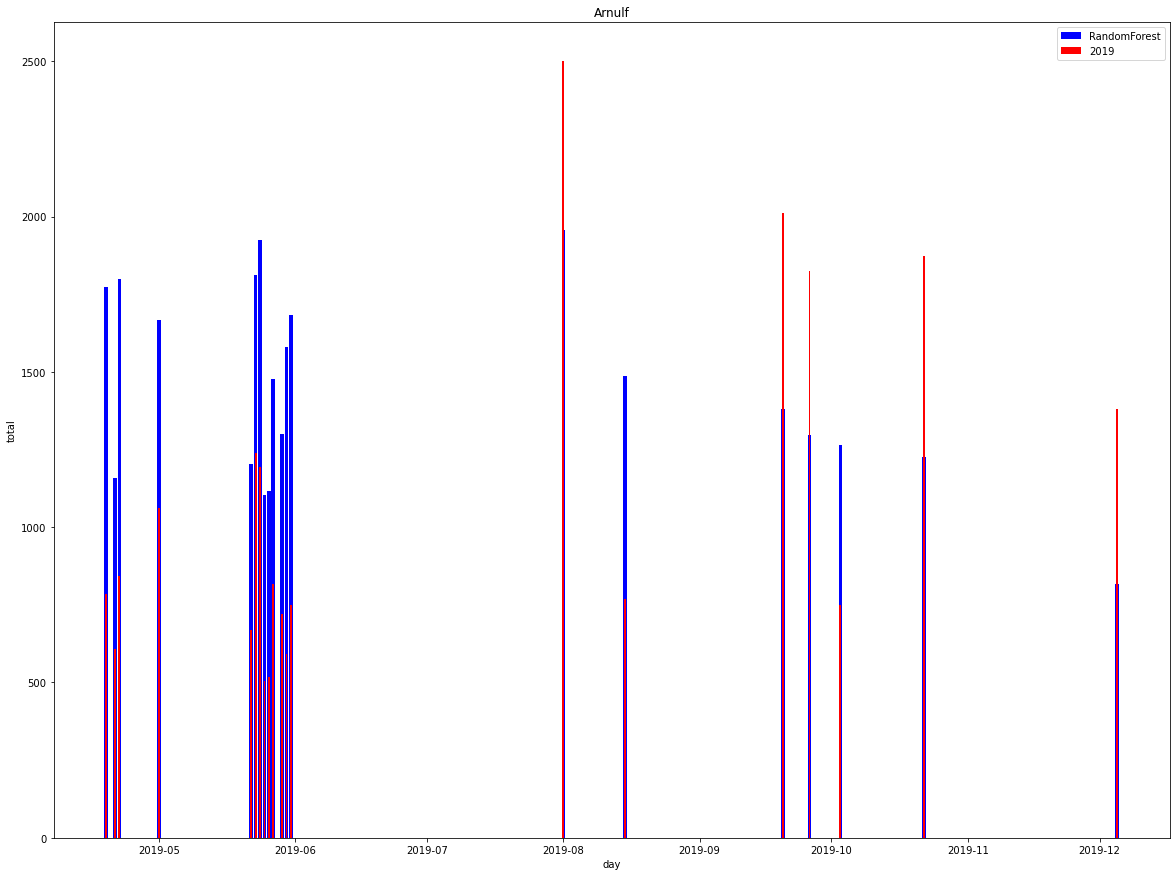

In [104]:
top_errors = df_errors.sort_values(by = 'error', ascending=False)[:20]
plotResults(top_errors, top_errors)

There is a week in may in which some errors occur.

### 5.3 NeuronalNet with new data

In [105]:
usedColumns[usedColumns!='datumDay']

array(['max-temp', 'datumDayofweek', 'sonnenstunden', 'min-temp',
       'datumDayofyear', 'niederschlag', 'datumWeek', 'bewoelkung',
       'feiertag', 'ferientag'], dtype=object)

In [106]:
# usedColumns = usedColumns[usedColumns!='datumDay'] #remove datumDay in future? it is the day in the month does it say sth dayInYear cannot say?

df_nn = getDataframe(zaehlstelle='Arnulf', prefixes = ('rad2017', 'rad2018', 'rad2019'))
df_nn['date'] = pd.to_datetime(df_nn['datum'], format="%Y.%m.%d")
df_nn = add_datepart(df_nn, 'datum')
add_date_feature(df_nn, 'feiertag', feiertage_df['date'])
add_date_feature(df_nn, 'ferientag', ferientage_df['date'])
df_nn = df_nn.drop(['richtung_1', 'richtung_2'], axis=1)
df_full = df_nn
df_nn = df_nn[list(usedColumns) + [dep_var]] #reduce columns after train valid set is created because year is used
df_nn

,max-temp,datumDayofweek,sonnenstunden,min-temp,datumDayofyear,niederschlag,datumWeek,bewoelkung,datumDay,feiertag,ferientag,gesamt
0,2.6,6,5.9,-6.1,1,0.0,52,36,1,True,False,135
1,0.8,0,0.3,-5.4,2,3.2,1,69,2,False,False,400
2,0.6,1,3.6,-2.1,3,0.0,1,85,3,False,False,262
3,1.3,2,0.0,-0.9,4,2.2,1,94,4,False,False,207
4,-0.2,3,0.0,-7.1,5,0.0,1,88,5,False,False,224
...,...,...,...,...,...,...,...,...,...,...,...,...
26,4.9,4,0.0,1.7,361,4.9,52,98,27,False,True,342
27,2.0,5,3.2,-2.1,362,0.0,52,69,28,False,True,374
28,2.5,6,7.9,-4.8,363,0.0,52,26,29,False,True,285
29,6.0,0,8.0,-4.4,364,0.0,1,9,30,False,True,602


I use the default value for `max_card=20` in comparison to the first run. Which leads to better continuos and categorical splits in my opinion. e.g. bewoelkung is now continous. I also tested it once with a dayOfYear as category but it let to worse performance.

In [107]:
cont_nn, cat_nn = cont_cat_split(df_nn, dep_var=dep_var)
#cont_nn.append('bewoelkung')
#cat_nn.remove('bewoelkung')

In [108]:
cont_nn, cat_nn

(['max-temp',
  'sonnenstunden',
  'min-temp',
  'datumDayofyear',
  'niederschlag',
  'bewoelkung',
  'datumDay'],
 ['datumDayofweek', 'datumWeek', 'feiertag', 'ferientag'])

In [109]:
df_nn[cat_nn].nunique()

datumDayofweek     7
datumWeek         52
feiertag           2
ferientag          2
dtype: int64

In [110]:
df_nn=df_nn.astype('float')
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn, procs_nn, cat_nn, cont_nn, splits=splits, y_names=dep_var)
dls = to_nn.dataloaders()

In [111]:
learn = tabular_learner(dls, n_out=1, loss_func=F.mse_loss) # removed all config params and just use default, model optimization is for another time

In [112]:
learn.fit_one_cycle(20, 1e-2)

epoch,train_loss,valid_loss,time
0,1816845.625000,1432133.000000,00:00
1,1808576.000000,1428485.875000,00:00
2,1781624.875000,1372125.625000,00:00
3,1593979.625000,813157.750000,00:00
4,1210289.750000,181425.625000,00:00
5,907380.125000,93933.218750,00:00
6,693443.375000,78018.203125,00:00
7,541596.625000,74059.382812,00:00
8,429904.500000,69380.671875,00:00
9,346007.937500,81721.476562,00:00


In [113]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

243.196913

In [114]:
print(mae(preds, targs).numpy())
print(mape(preds, targs).numpy())
print(nmae(preds, targs).numpy())

183.31126
0.27675143
0.1825398


Also better than previous model: 253 vs 287

### Check top errors

In [115]:
df_err_nn = df_full.iloc[valid_idx]

In [116]:
errors = pd.DataFrame(torch.sub(preds, targs).abs().numpy())

In [117]:
pd.options.mode.chained_assignment = None
df_err_nn['error'] = errors.to_numpy()
df_err_nn['pred'] = preds.numpy()

In [118]:
df_err_nn.columns

Index(['uhrzeit_start', 'uhrzeit_ende', 'datumWeek', 'zaehlstelle', 'gesamt',
       'min-temp', 'max-temp', 'niederschlag', 'bewoelkung', 'sonnenstunden',
       'date', 'datumYear', 'datumMonth', 'datumDay', 'datumDayofweek',
       'datumDayofyear', 'datumIs_month_end', 'datumIs_month_start',
       'datumIs_quarter_end', 'datumIs_quarter_start', 'datumIs_year_end',
       'datumIs_year_start', 'datumElapsed', 'feiertag', 'ferientag', 'error',
       'pred'],
      dtype='object')

In [119]:
pd.set_option('display.max_rows', 500)
df_err_nn.sort_values(by = 'error', ascending=False)[['date', 'datumDayofweek', 'min-temp', 'feiertag', 'ferientag', 'error', 'gesamt', 'pred']]

,date,datumDayofweek,min-temp,feiertag,ferientag,error,gesamt,pred
22,2019-05-23,3,7.6,False,False,804.707520,1239,2043.707520
23,2019-05-24,4,6.3,False,False,772.359619,1194,1966.359619
20,2019-05-21,1,10.5,False,False,718.092285,317,1035.092285
21,2019-05-22,2,8.8,False,False,677.635742,669,1346.635742
30,2019-05-31,4,11.7,False,False,667.846680,751,1418.846680
22,2019-08-23,4,11.4,False,True,661.843994,1778,1116.156006
27,2019-05-28,1,9.5,False,False,659.985962,396,1055.985962
28,2019-05-29,2,9.4,False,False,633.642822,722,1355.642822
25,2019-08-26,0,16.1,False,True,602.505859,1673,1070.494141
21,2019-08-22,3,13.0,False,True,595.103638,1956,1360.896362


In [120]:
pd.reset_option('display.max_rows')

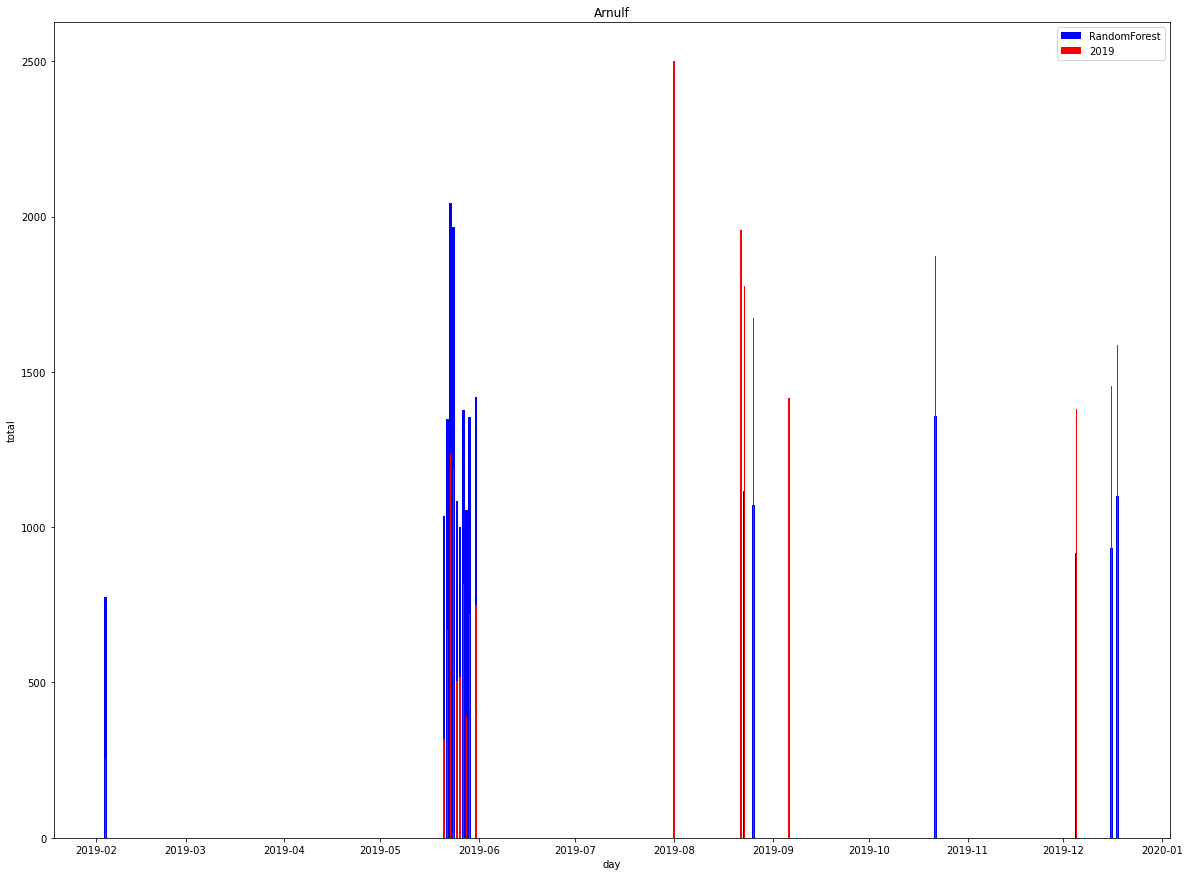

In [121]:
top_errors = df_err_nn.sort_values(by = 'error', ascending=False)[:20]
plotResults(top_errors, top_errors)

Also the neuronal net has quite high errors at the end of may, similiear to the RandomForest.

## 5. Conclusion <a name="conclusion"></a>

So what did I learn?

* RandomForest
    * good to use as a base model
    * nice visualisations for understanding important features (which can also be helpful for a neuronal net approach)
    * nice way to learn about the features and dataset
    * performs arround MAPE 33% and performs not as good as the neuronal net
    * Open Questions: Results change on every rerun. Therfore: How comparable are the results with the different changes then? Should I fix a seed for the RandomForest, is this possibl
* NeuronalNet
    * just used the default model of fastai (tabular learner)
    * performs arround MAPE 28%
    * in comparison to the RandomForest the reasons for a prediction are not traceable
* General
    * Great way to learn about biking habits in munich
    * Base models are good to improve dataset (e.g. add holidays)
    * I learned that biking is used for commuting (workday vs weekend) which is the most important feature. Temperature is also important but not as much as expected.
    * How to I evaluate models? How useful are they? What metrics should I use? I would like to compare them with real world usecases to check if they are helpful.
    * Predictions are possible with the shown ML approaches. I'm not sure if the would be helpful for traffic planers with the shown erros, but for a first try it looks promising.

#### Possible next steps:

* improve the neuronal net model by not using the default tabular learner and optimizing & thinking about an own architecture
* add more features to the dataset (e.g. Brückentage, days before long weekends, other weather information, ...?)
* train on a different bike counting station or sumup all counting stations into a total number for munich
* Use datasets where weekdays and weekends are seperated. Could I train a "Should I bike or take the bus?"-Model on this?


Do you have any notes, questions or found an error? Contact me: sven.adolph@pixel.de